# Behaviour Driving

The goal of this project is to teach a virtual vehicle to drive using only the driving data that we have collected in a simulator. This idea is most recently based on a paper by NVIDIA called [End To End Driving For Self-Driving Cars](https://arxiv.org/abs/1604.07316).

Useful Resources:
* [Steering Ratio](https://en.wikipedia.org/wiki/Steering_ratio)

## Loading The Dataset

In [287]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2

In [686]:
path = '../datasets/behavioural_driving/Dataset_2'
img_path = path + '/IMG'
models_path = "./models"

In [687]:
data_csv = pd.read_csv(path + '/driving_log.csv', header=None, 
                       names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"])
data_csv.head(n=10)

,Center,Left,Right,Steering Angle,Throttle,Brake,Speed
0,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.044182,0.987830,0,8.765856
1,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.098663,0.979730,0,10.083110
2,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,10.936000
3,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,12.136570
4,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,12.764350
5,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,13.870710
6,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.186713,0.975661,0,14.973310
7,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.174129,0.975661,0,16.186890
8,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.174129,0.975661,0,17.160210
9,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,/Users/eddieforson/Desktop/Behavioural_Driving...,-0.174129,0.975661,0,18.380120


In [688]:
img_count = data_csv.shape[0]
print("Dataset counts {0} rows".format(img_count))

Dataset counts 5105 rows


## Investigation distribution of stearing angles

Let's investigate the distribution of our steering angle data.

In [801]:
def get_steering_angles(data, st_column, st_calibrations):
    """
    Returns the steering angles for images referenced by the dataframe
    The caller must pass the name of the colum containing the steering angle 
    along with the appropriate steering angle corrections to apply
    """
    cols = len(st_calibrations)
    angles = np.zeros(len(data) * cols, dtype=np.float32)

    for i, row in data.iterrows():
        st_angle = row[st_column]
        for (j,st_calib) in enumerate(st_calibrations):                    
            angles[i * cols + j] = st_angle + st_calib
    
    # Let's not forget to ALWAYS clip our angles within the [-1,1] range
    return np.clip(angles, -1, 1)

In [802]:
st_angle_names = ["Center", "Left", "Right"]
st_angle_calibrations = [0, 0.25, -0.25]
st_angles = get_steering_angles(data_csv, "Steering Angle", st_angle_calibrations)

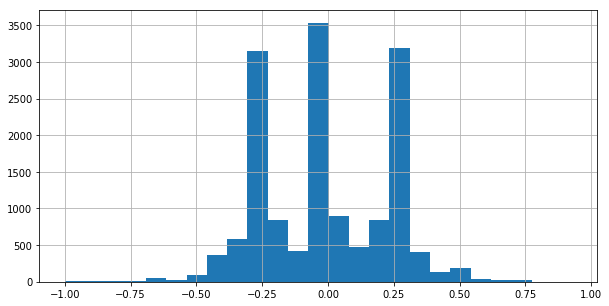

In [803]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(True)
count, bins, _ = ax.hist(st_angles, bins=25,histtype='bar' )

The dataset is greatly relatively balanced; this could be explained by the fact that we drove the car in both directions during our training, therefore equalizing the left and right turns. We can see that we have however taken bigger turns on the left. The car is also more often at a slightly negative steering angle, which would point to the fact that **our model may be biased to turning left more frequently**.

## Load Images

In [342]:
def read_img(img_name, path):
    img_path = "{0}/{1}".format(path, img_name)
    img = cv2.imread(img_path)
    # Converting image to RGB
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Build A Generator

We are going to build a Keras generator to be able to perform real-time augmentations when training the model. The first step we have to do though is to define all our augmentations.

### Implementation Image Augmentation Functions

In [804]:
def fliph_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)

In [805]:
def change_image_lightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'L' component of the supplied image in HSL format
    The returned image in converted back to RGB
    """
    # Convert to HSL (HLS in OpenCV!!)
    hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
    hls = hls.astype(int)    
    
    # Add an offset to light component 
    offset = np.random.randint(low, high=high)
    # Since the format is HLS and NOT HSL, it is the second component (index 1) that is modified
    hls[:,:,1] += offset

    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hls, 0, 255)
    
    # Convert back to uint
    hls = hls.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB) 

In [861]:
def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image with a probability p
    """
    aug_img = img
    
    # Augment image 50% of the time
    prob = np.random.random_sample()
        
    if prob <= p: 
        # Try horizontal flip
        aug_img = fliph_image(img)
        st_angle = st_angle * (-1)
    
    if prob <= p: 
        # Try Changes in brightness
        aug_img = change_image_lightness(aug_img, -40, 80)
    
    # Try adding shadows
        
    return aug_img, st_angle

In [862]:
def generate_images(df, target_dimensions, img_types, st_column, st_angle_calibrations, batch_size=100, shuffle=True):
    """
    Generates images whose paths and steering angle are stored in supplied dataframe object df
    Returns the tuple (batch,steering_angles)
    """
    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    df_len = len(df)
    img_types = ["Center", "Left", "Right"]
    st_angle_calibrations = [0, 0.35, -0.25]
    
    while True:
        k = 0
        while k < batch_size:            
            idx = np.random.randint(0, df_len)       

            for img_t, st_calib in zip(img_types, st_angle_calibrations):
                row = df.iloc[idx]
                st_angle = row[st_column] + st_calib
                img_type_path = row[img_t]  
                img = read_img(img_type_path.split("/")[-1], img_path)
                
                img, st_angle = augment_image(img, st_angle, 0.7)
                batch[k] = img
                steering_angles[k] = st_angle
                k += 1
        
        yield batch, steering_angles            

### Viewing Some Of Our Augmented Images

We view the results of the augmentations in this section.

In [911]:
def show_images(imgs, labels, cols=5, fig_size=(15, 5)):
    rows = len(imgs) // cols
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r,c]
            img = imgs[cols * r + c]
            lb = labels[cols * r + c]
            ax.imshow(img.astype(np.uint8))
            ax.axis('off')
            ax.set_aspect('equal')
            ax.set(title=lb)
    fig.tight_layout()
    plt.show()
    

In [899]:
gen = generate_images(data_csv, (160, 320, 3), st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

In [900]:
b, s = next(gen)

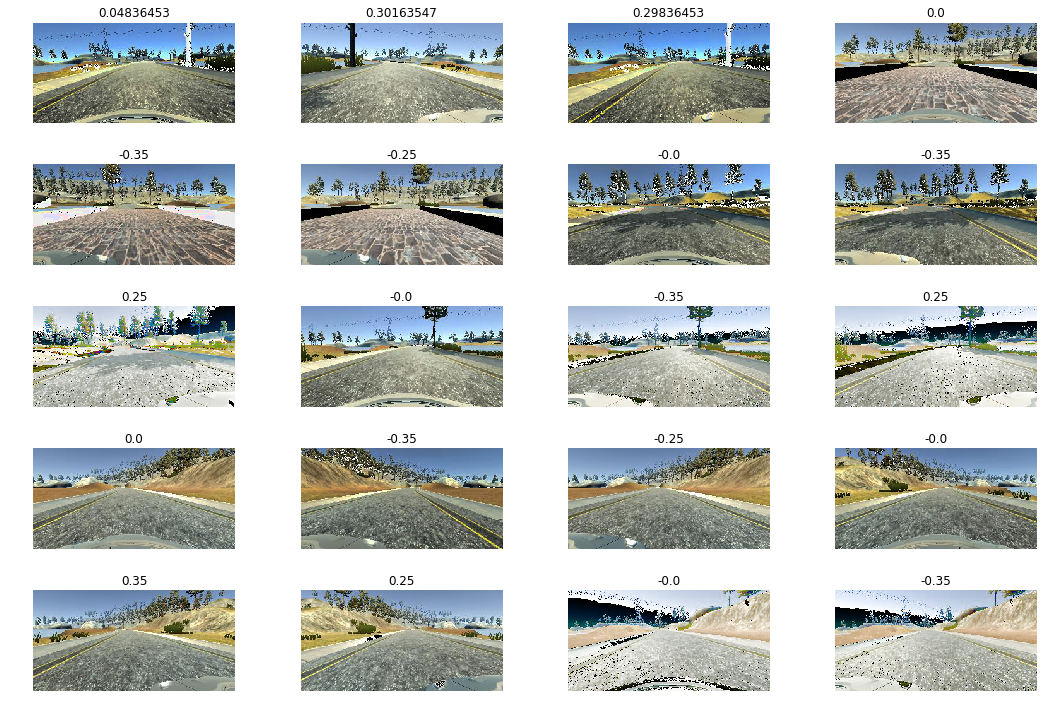

In [912]:
show_images(b[0:20], s[0:20], cols=4, fig_size=(15, 10))

We can observe that the images are well augmented. This should hopefully help our model generalise

## Build A Neural Net To Predict Steering Angles

We are using Keras, which in turn delegates to Tensorflow under the hood. Let's import all the functions we need.

In [926]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

In [914]:
# Let's also define the input shape
in_shape = (160, 320, 3)

### Simple Model

In this section we create a simple model to predict steering angles. There are no convolutions in this architecture, and since this is a pure _regression_ problem, and not a _classification_ one, we will be using the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the activation function in the last layer.

In [77]:
def simple_model():
    model = Sequential()
    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam", metrics=['accuracy'])
    return model

In [78]:
m = simple_model()
history = m.fit(X_train, y_train, nb_epoch=50, validation_split=0.2, shuffle=True, verbose=0)

In [ ]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_acc'])

In [ ]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_loss'])

In [81]:
m.save("{0}/simple_model.h5".format(models_path))

In [108]:
def plot_results(hist, metrics, xlb, ylb, title, leg, fsize = (10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:        
        ax.plot(hist.history[m])
    
    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

In [ ]:
plot_results(history, ["acc", "val_acc"], "epoch", "accuracy", "Accuracy vs Epochs", ["Training", "Validation"])

In [ ]:
plot_results(history, ["loss", "val_loss"], "epoch", "loss", "Loss vs Epochs", ["Training", "Validation"])

We are not getting a stable network at all. The loss is erratic as well as the accuracy, and we are barely reaching 0.1% on the training set. We will explore next the architecture employed by the team from the NVIDIA paper.

## NVIDIA Model

### Pre-processing steps

In [381]:
mean_r = np.average(X_train[:,:,:,0])
mean_g = np.average(X_train[:,:,:,1])
mean_b = np.average(X_train[:,:,:,2])

In [382]:
mean_channels = [mean_r, mean_g, mean_b]
print("Mean for channels is {0}".format(mean_channels))

Mean for channels is [136.19009391165321, 142.25525395939627, 133.84246425028346]


In [460]:
def crop(imgs):
    return imgs[:,crop_y_start:,:,:]

In [461]:
def resize(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [66, 200])

In [462]:
def normalize_mean_channels(img):
    return img - [136.19009391165321, 142.25525395939627, 133.84246425028346]

In [930]:
def nvidia_model(target_shape, crop_y_start):
    model = Sequential()
    # Cropping image
    model.add(Lambda(lambda imgs: imgs[:,60:,:,:], input_shape=(160, 320, 3)))
    # Normalise the image
    model.add(Lambda(lambda imgs: (imgs/255)))
#    model.add(Lambda(normalize_mean_channels))
    model.add(Lambda(resize))
    
    # TODO use Keras.Cropping instead of a lambda layer

    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))    
    model.add(BatchNormalization())

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='elu')) 
    model.add(BatchNormalization())

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='elu')) 
    model.add(BatchNormalization())

    #model.add(BatchNormalization())
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(1164, activation='elu'))

    model.add(Dense(100, activation='elu'))

    model.add(Dense(50, activation='elu'))

    model.add(Dense(10, activation='elu'))

    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = Adam(lr = 0.001))
    return model 

In [931]:
t_shape = (66,200,3)
m = nvidia_model(t_shape, crop_y_start)

In [932]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_81 (Lambda)               (None, 100, 320, 3)   0           lambda_input_60[0][0]            
____________________________________________________________________________________________________
lambda_82 (Lambda)               (None, 100, 320, 3)   0           lambda_81[0][0]                  
____________________________________________________________________________________________________
lambda_83 (Lambda)               (None, 66, 200, 3)    0           lambda_82[0][0]                  
____________________________________________________________________________________________________
convolution2d_201 (Convolution2D (None, 31, 98, 24)    1824        lambda_83[0][0]                  
___________________________________________________________________________________________

In [923]:
b_size = len(data_csv) // 10
b_size

510

In [933]:
gen = generate_images(data_csv, in_shape, st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

In [935]:
m.fit_generator(gen, samples_per_epoch=b_size * 20, nb_epoch=5, verbose=1)

Epoch 1/5
10200/10200 [==============================] - 27s - loss: 0.0251    
Epoch 2/5
10200/10200 [==============================] - 27s - loss: 0.0228    
Epoch 3/5
10200/10200 [==============================] - 27s - loss: 0.0207    
Epoch 4/5
10200/10200 [==============================] - 27s - loss: 0.0198    
Epoch 5/5
10200/10200 [==============================] - 27s - loss: 0.0181    


In [790]:
m.save("{0}/nivida_model_4.h5".format(models_path))

In [543]:
from keras.models import load_model,model_from_json

In [544]:
#m2 = load_model("{0}/nivida_model.h5".format(models_path), custom_objects={"tf": backend.tf})
m2 = load_model("{0}/nivida_model_4.h5".format(models_path))

In [261]:
m.to_json()

'{"keras_version": "1.2.1", "config": [{"config": {"batch_input_shape": [null, 160, 320, 3], "arguments": {}, "trainable": true, "output_shape": null, "output_shape_type": "raw", "function": ["\\u00e3\\u0001\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u0002\\u0000\\u0000\\u0000\\u0004\\u0000\\u0000\\u0000C\\u0000\\u0000\\u0000s)\\u0000\\u0000\\u0000d\\u0001\\u0000d\\u0002\\u0000l\\u0000\\u0000m\\u0001\\u0000}\\u0001\\u0000\\u0001|\\u0001\\u0000j\\u0002\\u0000j\\u0003\\u0000|\\u0000\\u0000d\\u0003\\u0000d\\u0004\\u0000g\\u0002\\u0000\\u0083\\u0002\\u0000S)\\u0005N\\u00e9\\u0000\\u0000\\u0000\\u0000)\\u0001\\u00da\\u0002tf\\u00e9B\\u0000\\u0000\\u0000\\u00e9\\u00c8\\u0000\\u0000\\u0000)\\u0004\\u00da\\rkeras.backendr\\u0002\\u0000\\u0000\\u0000\\u00da\\u0005image\\u00da\\rresize_images)\\u0002\\u00da\\u0003img\\u00da\\u0003ktf\\u00a9\\u0000r\\n\\u0000\\u0000\\u0000\\u00fa <ipython-input-253-763cb1c42d3c>\\u00da\\u0006resize\\u0001\\u0000\\u0000\\u0000s\\u0004\\u0000\\u0000\\u0000\\

In [ ]:
model2 = model_from_json(m.to_json(), custom_objects={"ktf.image.resize_images": ktf.image.resize_images})